<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/mlflow/custom/FineTuned_Vit_to_ONNX_save_to_MLFLOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Transformer

The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels.

Images are presented to the model as a sequence of fixed-size patches (resolution 16x16), which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder.

Note that this model does not provide any fine-tuned heads, as these were zero'd by Google researchers. However, the model does include the pre-trained pooler, which can be used for downstream tasks (such as image classification).

By pre-training the model, it learns an inner representation of images that can then be used to extract features useful for downstream tasks: if you have a dataset of labeled images for instance, you can train a standard classifier by placing a linear layer on top of the pre-trained encoder. One typically places a linear layer on top of the [CLS] token, as the last hidden state of this token can be seen as a representation of an entire image.


https://huggingface.co/google/vit-base-patch16-224-in21k


###Paper
https://arxiv.org/pdf/2010.11929



### Training data
The ViT model was pretrained on ImageNet-21k, a dataset consisting of 14 million images and 21k classes. https://www.image-net.org/

### MLFLOW
A Tool for Managing the Machine Learning Lifecycle
MLflow is an open-source platform, purpose-built to assist machine learning practitioners and teams in handling the complexities of the machine learning process. MLflow focuses on the full lifecycle for machine learning projects, ensuring that each phase is manageable, traceable, and reproducible.


https://mlflow.org/docs/latest/index.html

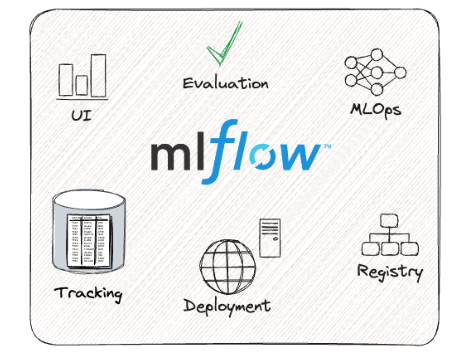

# ONNX (Open Neural Network Exchange)
- https://onnx.ai/onnx/

### ONNX Runtime
ONNX Runtime is a cross-platform machine-learning model accelerator, with a flexible interface to integrate hardware-specific libraries. ONNX Runtime can be used with models from PyTorch, Tensorflow/Keras, TFLite, scikit-learn, and other frameworks.

https://onnxruntime.ai/docs/



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mlflow   optimum open_clip_torch --quiet

! pip install psutil pynvml -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.0/623.0 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11

In [3]:
# Transformers installation

! pip install transformers[torch] -q
! pip install accelerate -U -q
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

In [4]:
! pip install onnxruntime -q
! pip install optimum[onnxruntime] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 108.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 104.6 MB/s eta 0:00:00


In [5]:
path_model ="/content/drive/MyDrive/models/nsfw_pytorch"

In [6]:
from google.colab import userdata

from transformers import ViTImageProcessor, ViTForImageClassification
import os
import sys
import platform
from PIL import Image

In [7]:


from datasets import load_dataset
from functools import partial
import os

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset
from torch import cuda, bfloat16
import transformers
import openai

import torch.nn as nn
from google.colab import userdata
import mlflow
import numpy as np

In [8]:

from google.colab import output
output.enable_custom_widget_manager()

from transformers.utils import logging
from transformers import pipeline

In [9]:
logging.set_verbosity_error()

os.environ["TRANSFORMERS_VERBOSITY"] = "error"

In [10]:


device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
device


'cuda:0'

In [11]:
MLFLOW_TRACKING_URI="databricks"
# Specify the workspace hostname and token
DATABRICKS_HOST="https://adb-2467347032368999.19.azuredatabricks.net/"
DATABRICKS_TOKEN=userdata.get('DATABRCKS_TTOKEN')

In [12]:


if "MLFLOW_TRACKING_URI" not in os.environ:
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
if "DATABRICKS_HOST" not in os.environ:
    os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST
if "DATABRICKS_TOKEN" not in os.environ:
    os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN

In [13]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [14]:

mlflow.set_experiment("/Users/***REMOVED***/nsfw_onnx")


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/2536323363862885', creation_time=1734455772600, experiment_id='2536323363862885', last_update_time=1734512189610, lifecycle_stage='active', name='/Users/***REMOVED***/nsfw_onnx', tags={'mlflow.experiment.sourceName': '/Users/***REMOVED***/nsfw_onnx',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': '***REMOVED***',
 'mlflow.ownerId': '1331640755799986'}>

In [15]:
mlflow.end_run()

In [16]:

processor = ViTImageProcessor.from_pretrained(path_model)
model = ViTForImageClassification.from_pretrained(path_model)
model = model.to("cpu")

In [17]:
image_path = "/content/drive/MyDrive/data/beach.jpg"
image = Image.open(image_path).convert("RGB")

In [18]:
np.array(image).shape

(359, 479, 3)

array([[[133, 133, 145],
        [137, 137, 149],
        [131, 133, 145],
        ...,
        [149, 117,  68],
        [ 98,  65,  14],
        [138, 102,  54]],

       [[130, 130, 142],
        [132, 132, 144],
        [127, 129, 141],
        ...,
        [130,  98,  47],
        [101,  68,  15],
        [161, 125,  75]],

       [[127, 129, 142],
        [126, 128, 141],
        [125, 127, 140],
        ...,
        [147, 116,  62],
        [152, 119,  65],
        [139, 108,  53]],

       ...,

       [[111, 111, 111],
        [112, 112, 112],
        [112, 112, 112],
        ...,
        [ 95,  64,  33],
        [ 95,  64,  33],
        [ 98,  67,  38]],

       [[111, 111, 111],
        [111, 111, 111],
        [111, 111, 111],
        ...,
        [ 94,  63,  32],
        [ 93,  62,  31],
        [ 95,  64,  35]],

       [[113, 113, 111],
        [114, 114, 112],
        [114, 114, 112],
        ...,
        [ 97,  66,  35],
        [ 95,  64,  33],
        [ 99,  68,  39]]], dtype=uint8)
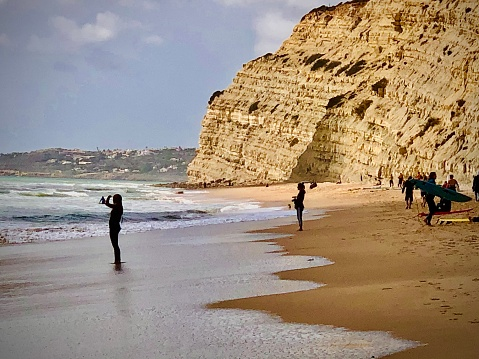

In [19]:
np.array(image)

In [20]:
inputs = processor(images=image, return_tensors="pt")

input_tensor = inputs["pixel_values"]

In [21]:
path_model_onnx ="/content/drive/MyDrive/models/nsfw_pytorch/onnx"

In [22]:
torch.onnx.export(
    model=model,
    args=(input_tensor,),
    f=f"{path_model_onnx}/vit_nsfw.onnx",
    opset_version=14,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:172: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:178: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


In [23]:
import onnxruntime
from PIL import Image
import numpy as np
import os
import datetime

In [24]:
ort_sess = onnxruntime.InferenceSession(
   f"{path_model_onnx}/vit_nsfw.onnx", providers=["CPUExecutionProvider"]
)

In [25]:
input_name = ort_sess.get_inputs()[0].name
output_name = ort_sess.get_outputs()[0].name

img_paths = [image_path]

label_dic = {"drawings": 0, "hentai": 1, "neutral": 2, "porn": 3, "sexy": 4}

In [26]:
def get_key(dict, value):
    """
    return key given a value. From a dictionary
    """
    for key, val in dict.items():
        if val == value:
            return key
    return "Value not found"


def load_img(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224), Image.BILINEAR)
    img = np.array(image, dtype=np.float32)
    img /= 255.0
    img = np.transpose(img, (2, 0, 1))
    return img

In [27]:

time1 = datetime.datetime.now()

inputs = np.array([load_img(path) for path in img_paths])
outputs = ort_sess.run([output_name], {input_name: inputs})[0]

logits = np.array(outputs)

probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

predicted_class = np.argmax(probabilities, axis=1)

print("Predicted classes :", predicted_class)
print("\n")
output_probs = {}
for prob, key in zip(probabilities[0], range(0, len(probabilities[0]))):
    label = get_key(label_dic, key)
    output_probs[label] = float(prob)
time2 = datetime.datetime.now()
print(output_probs)
secs = time2 - time1
print(f"Time: {secs}")

Predicted classes : [2]


{'drawings': 0.008857411332428455, 'hentai': 0.001359450165182352, 'neutral': 0.9857551455497742, 'porn': 0.001926638651639223, 'sexy': 0.002101368270814419}
Time: 0:00:00.165711


In [28]:

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.pyfunc import PythonModel
import pprint



In [29]:
class NSFW_Classifier_ONNX(PythonModel):

  def load_context(self, context):
        """
        This method initializes the tokenizer and language model
        using the specified model snapshot directory.
        """

        import onnxruntime
        from PIL import Image
        import numpy as np
        import os
        global label_dic
        label_dic = {"drawings": 0, "hentai": 1, "neutral": 2, "porn": 3, "sexy": 4}
        self.model = onnxruntime.InferenceSession( context.artifacts["snapshot"], providers=["CPUExecutionProvider"])
        self.input_name = self.model.get_inputs()[0].name
        self.output_name = self.model.get_outputs()[0].name

  def get_key(self, dict, value):
      """
      return key given a value. From a dictionary
      """
      for key, val in dict.items():
          if val == value:
              return key
      return "Value not found"


  def load_img(self, path):
      image = Image.open(path).convert("RGB")
      image = image.resize((224, 224), Image.BILINEAR)
      img = np.array(image, dtype=np.float32)
      img /= 255.0
      img = np.transpose(img, (2, 0, 1))
      return img


  def predict(self, context, model_input, params=None):
        """
        This method generates prediction for the given input.
        """
        path_image = model_input["path_image"][0]
        inputs = np.array([load_img(path=path_image)])
        outputs = self.model.run([self.output_name], {self.input_name: inputs})[0]

        logits = np.array(outputs)

        probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

        predicted_class = np.argmax(probabilities, axis=1)
        output_probs = {}
        for prob, key in zip(probabilities[0], range(0, len(probabilities[0]))):
            label = self.get_key(label_dic, key)
            output_probs[label] = float(prob)

        return output_probs


In [30]:
import numpy as np
import pandas as pd

import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types import ColSpec, DataType, ParamSchema, ParamSpec, Schema

from mlflow.models import infer_signature

model_output= {'drawings': 0.008857411332428455, 'hentai': 0.001359450165182352, 'neutral': 0.9857551455497742, 'porn': 0.001926638651639223, 'sexy': 0.002101368270814419}

model_input= {"path_image":"/content/drive/MyDrive/data/beach.jpg"}


signature = infer_signature(model_input=model_input,model_output=model_output)



# Define input example
input_example = {"path_image":"/content/drive/MyDrive/data/beach.jpg"}

In [31]:
signature

inputs: 
  ['path_image': string (required)]
outputs: 
  ['drawings': double (required), 'hentai': double (required), 'neutral': double (required), 'porn': double (required), 'sexy': double (required)]
params: 
  None

In [32]:
input_example

{'path_image': '/content/drive/MyDrive/data/beach.jpg'}

In [33]:
import datetime
now = datetime.datetime.now()
now.strftime("%Y-%m-%d_%H:%M:%S")

'2024-12-18_17:55:35'

In [34]:
# Get the current base version of torch that is installed, without specific version modifiers
torch_version = torch.__version__.split("+")[0]

In [35]:

# Start an MLflow run context and log the PHi3 model wrapper along with the param-included signature to
# allow for overriding parameters at inference time
now = datetime.datetime.now()

description= """Log NSFW fine tunned model with mlflow converted to ONNX to be used only in CPU"""
with mlflow.start_run(run_name=f"nsfw_onnx_log_{now.strftime('%Y-%m-%d_%H:%M:%S')}", description=description) as run:
    model_info = mlflow.pyfunc.log_model(
        "nsfw_image_classification",
        python_model=NSFW_Classifier_ONNX(),
        # NOTE: the artifacts dictionary mapping is critical! This dict is used by the load_context() method in our PHi3() class.
        artifacts={"snapshot": "/content/drive/MyDrive/models/nsfw_pytorch/onnx/vit_nsfw.onnx"},

        pip_requirements=[
            f"torch=={torch_version}",
            f"transformers=={transformers.__version__}",
            "pillow",
            "onnxruntime",
            "numpy",

        ],
        input_example=input_example,
        signature=signature,
    )

/content/drive/MyDrive/data/beach.jpg


Uploading artifacts:   0%|          | 0/8 [00:00<?, ?it/s]

🏃 View run nsfw_onnx_log_2024-12-18_17:55:41 at: https://adb-2467347032368999.19.azuredatabricks.net/ml/experiments/2536323363862885/runs/235de83335aa4354bfea579b0a0b2010
🧪 View experiment at: https://adb-2467347032368999.19.azuredatabricks.net/ml/experiments/2536323363862885


In [36]:
run.to_dictionary()

{'info': {'artifact_uri': 'dbfs:/databricks/mlflow-tracking/2536323363862885/235de83335aa4354bfea579b0a0b2010/artifacts',
  'end_time': None,
  'experiment_id': '2536323363862885',
  'lifecycle_stage': 'active',
  'run_id': '235de83335aa4354bfea579b0a0b2010',
  'run_name': 'nsfw_onnx_log_2024-12-18_17:55:41',
  'run_uuid': '235de83335aa4354bfea579b0a0b2010',
  'start_time': 1734544542181,
  'status': 'RUNNING',
  'user_id': ''},
 'data': {'metrics': {},
  'params': {},
  'tags': {'mlflow.note.content': 'Log NSFW fine tunned model with mlflow converted to ONNX to be used only in CPU',
   'mlflow.runColor': '#87cebf',
   'mlflow.runName': 'nsfw_onnx_log_2024-12-18_17:55:41',
   'mlflow.source.name': '/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py',
   'mlflow.source.type': 'LOCAL',
   'mlflow.user': '1331640755799986'}}}

In [37]:

model_info.model_uri

'runs:/235de83335aa4354bfea579b0a0b2010/nsfw_image_classification'

In [38]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

In [39]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: nsfw_image_classification
  flavor: mlflow.pyfunc.model
  run_id: 235de83335aa4354bfea579b0a0b2010

In [42]:

time1=  datetime.datetime.now()
response = loaded_model.predict({"path_image":"/content/drive/MyDrive/data/beach.jpg"})
time2=  datetime.datetime.now()
print(time2-time1)

/content/drive/MyDrive/data/beach.jpg
0:00:00.131029


In [43]:

pprint.pprint(response)

{'drawings': 0.008857411332428455,
 'hentai': 0.001359450165182352,
 'neutral': 0.9857551455497742,
 'porn': 0.001926638651639223,
 'sexy': 0.002101368270814419}


In [44]:
result = mlflow.register_model(
    model_info.model_uri, "vit_nsfw_onnx"
)

Registered model 'vit_nsfw_onnx' already exists. Creating a new version of this model...
2024/12/18 18:28:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: vit_nsfw_onnx, version 3
Created version '3' of model 'vit_nsfw_onnx'.


In [45]:
from mlflow import MlflowClient

client = MlflowClient()

In [46]:
client.get_model_version(name="vit_nsfw_onnx", version=3)

<ModelVersion: aliases=[], creation_timestamp=1734546495797, current_stage='None', description='', last_updated_timestamp=1734546509245, name='vit_nsfw_onnx', run_id='235de83335aa4354bfea579b0a0b2010', run_link='', source='dbfs:/databricks/mlflow-tracking/2536323363862885/235de83335aa4354bfea579b0a0b2010/artifacts/nsfw_image_classification', status='READY', status_message='', tags={}, user_id='***REMOVED***', version='3'>

In [47]:
import mlflow.pyfunc

model_name = "vit_nsfw_onnx"
model_version = 3

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

result= model.predict({"path_image":"/content/drive/MyDrive/data/beach.jpg"})

2024/12/18 18:31:36 INFO mlflow.utils.databricks_utils: No workspace ID specified; if your Databricks workspaces share the same host URL, you may want to specify the workspace ID (along with the host information in the secret manager) for run lineage tracking. For more details on how to specify this information in the secret manager, please refer to the Databricks MLflow documentation.


/content/drive/MyDrive/data/beach.jpg


In [48]:
pprint.pprint(result)

{'drawings': 0.008857411332428455,
 'hentai': 0.001359450165182352,
 'neutral': 0.9857551455497742,
 'porn': 0.001926638651639223,
 'sexy': 0.002101368270814419}


In [49]:
f"models:/{model_name}/{model_version}"

'models:/vit_nsfw_onnx/3'